# Importing Libraries

In [1]:
import os
import cv2
import copy
import csv
import random
import pickle
import numpy as np
import pandas as pd
import itertools
from scipy.stats import randint
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [4]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from skimage.feature import hog, local_binary_pattern

# Defining Functions

In [5]:
def write_csv(file, a1, a2, a3, a4, a5, a6, a7, name):
    with open(file, mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(name)
        for i in range(20):
            if a2[i] == None:
                a2[i] = 'None'
            if a4[i] == None:
                a4[i] = 'None'
            csv_writer.writerow([a1[i], a2[i], a3[i], a4[i], a5[i], a6[i], a7[i]])

In [6]:
def read_images(path):
    images = []
    labels = []
    num1 = 32
    num2 = 32
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (num2, num1))
                    images.append(new_img)
                    if file_name == 'Parasitized':
                        label = 0
                    else:
                        label = 1
                    labels.append(label)
    
    return np.array(images), np.array(labels)

In [7]:
def save_feature(feature, name):
    # saving all our feature vectors in pickled file
    with open('cache/' + name + '.pkl', 'wb') as fp:
        pickle.dump(csr_matrix(feature), fp)
    
    print(f'Feature saved with name cache/{name}.pkl')

def load_feature(feature_name):
    return pickle.load(open(feature_name, 'rb')).A

In [8]:
def save_model(model):
    filename = input('Enter model file name:')
    pickle.dump(model, open('models/'+filename + '.pkl', 'wb'))
    print(f'Successfully saved model in models/{filename}.pkl')

def load_model(model_name):
    return pickle.load(open(model_name, 'rb'))

Flattened Image Feature

In [9]:
def get_flattened(images, color=cv2.COLOR_RGB2GRAY, name='flattened', save=False):
    """
    color: default RGB2GRAY, if None is passed then color is used as it is.
    """
    color_images = []
    if color is not None:
        for img in images:
            color_images.append(cv2.cvtColor(img, color))
    else:
        color_images = images
    
    count = len(color_images)
    
    result = np.array(color_images).reshape(count, -1)
    
    if save:
        save_feature(result, name)
        
    return result

Color Histograms Feature

In [10]:
def get_color_hist(images, name='color_hist', save=False):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    
    if save:
        save_feature(result, name)
        
    return result

HOG based Features

In [11]:
def get_hog(images, name='hog', save=False):
    result = np.array([hog(img, block_norm='L2') for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

KAZE based features

In [12]:
def get_kaze(images, name='kaze', save=False):
    # KAZE descriptor for 1 image
    def get_image_kaze(image, vector_size=32):
        alg = cv2.KAZE_create()
        kps = alg.detect(image)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
        return dsc
    
    # KAZE descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_kaze(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

SIFT based Feature

In [13]:
def get_sift(images, name='sift', save=False):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=15):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [15]:
def return_sift_kp(image):
    alg = cv2.xfeatures2d.SIFT_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:15]

    # Making descriptor of same size
    # Descriptor vector size is 128
    needed_size = (15 * 128)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

In [16]:
def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=4):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
    
    if save:
        save_feature(result, name)
        
    return result

In [17]:
def return_surf_kp(image):
    alg = cv2.xfeatures2d.SURF_create()
    kps = alg.detect(image, None)
    kps = sorted(kps, key=lambda x: -x.response)[:4]

    # Making descriptor of same size
    # Descriptor vector size is 64
    needed_size = (15 * 64)
    if len(kps) == 0:
        dsc = np.zeros(needed_size)
    else:
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return kps

LBP Feature

In [18]:
def get_lbp(images, name='lbp', save=False):
    result = np.array([local_binary_pattern(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 10, 3).flatten() for img in images])
    
    if save:
        save_feature(result, name)
        
    return result

In [19]:
def combine_features(features, horizontal=True):
    """
    Array of features [f1, f2, f3] where each fi is a feature set 
    eg. f1=rgb_flat, f2=SIFT, etc.
    """
    if horizontal:
        return np.hstack(features)
    else:
        return np.vstack(features)

Normalize features

In [20]:
def norm_features_minmax(train, test):
    min_max_scaler = preprocessing.MinMaxScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

In [21]:
def norm_features_zscore(train, test):
    min_max_scaler = preprocessing.StandardScaler()
    norm_train = min_max_scaler.fit_transform(train)
    norm_test = min_max_scaler.transform(test)
    
    return norm_train, norm_test

Classifiers

In [22]:
def train_model(train_x, train_y, model_name='NB', validation=None):
    """
    Possible model names: ['NB', 'SVM', 'XGB', 'MLP', 'ADA', 'BAG', 'RF']
    default = 'NB'
    
    validation: (val_x, val_y) tupple for validation accuracy score.
    
    return: trained model
    """
    model = None
    if model_name == 'SVM':
        model = svm.SVC(gamma='scale', probability=True)
    elif model_name == 'XGB':
        model = XGBClassifier(n_estimators=200, max_depth=5, n_jobs=2)
#         model = XGBClassifier()
    elif model_name == 'MLP':
        model = MLPClassifier(hidden_layer_sizes=(100,100,100), max_iter=800, alpha=0.0001,
                     solver='sgd', verbose=10, tol=0.000000001)
    elif model_name == 'ADA':
        model = AdaBoostClassifier(n_estimators=50)
    elif model_name == 'BAG':
        model = BaggingClassifier(n_jobs=2, n_estimators=50)
    elif model_name == 'RF':
        model = RandomForestClassifier(n_estimators=200, max_depth=10)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
    else:
        model = GaussianNB()
    
    model.fit(train_x, train_y)
    
    if validation is not None:
        y_hat = model.predict(validation[0])
        acc = metrics.accuracy_score(validation[1], y_hat)
        print(f"Validation Accuracy in '{model_name}' = {acc}")
        cm = metrics.confusion_matrix(validation[1], y_hat)
        print(cm)
        recall = cm[0][0] / (cm[0][0] + cm[0][1])
        precision = cm[0][0] / (cm[0][0] + cm[1][0])
        f1 = 2*(precision*recall)/(precision+recall)
        print(f"Recall in '{model_name}' = {recall}")
        print(f"Precision in '{model_name}' = {precision}")
        print(f"F1 Score in '{model_name}' = {f1}")
               
    return model

ROC

In [23]:
def plot_roc(fpr, tpr, class_name, area):
    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.plot(fpr,tpr)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

In [24]:
def plot_combine_roc(test_y, prob):
    n_classes = 7
    name_arr = ['RF', 'BAG', 'ADA', 'NB', 'SVM', 'XGB', 'KNN']
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(test_y, prob[:, i])
        roc_auc[i] = metrics.roc_auc_score(test_y,  prob[:, i])

    figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
    colors = cycle(['darkorange', 'cornflowerblue', 'red', 'purple', 'pink', 'violet', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve for ' + name_arr[i] + ' class (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.savefig('output/roc_lda_on_pca_uninfected.png')
    plt.show()

Confusion Matrix

In [25]:
def confusion_mat(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.grid(False)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

PCA projected data

In [26]:
def pca_projection(mat, name_arr):
    plt.figure(figsize=(15,20))
    for i, img in enumerate(mat, start=1):
        plt.subplot(4, 2, i)
        y = np.var(mat[i-1], axis=0)
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '--o')
        plt.ylabel('Variance')
        plt.xlabel('Data Projected on Eigen Vector Number')
        plt.xticks(x)
        plt.title(name_arr[i-1])
    plt.savefig('output/pca/subplot.jpg')
    plt.show()

In [27]:
def draw_key_points(image, kp):
    img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return img

# Data Preparation

In [28]:
full_data_x, full_data_y = read_images('cell_images')

In [29]:
full_data_x.shape, full_data_y.shape

((27558, 32, 32, 3), (27558,))

In [30]:
full_data_x[2].shape

(32, 32, 3)

In [31]:
data_x, test_x, data_y, test_y = train_test_split(full_data_x, full_data_y, test_size=0.2)


In [32]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape


((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [33]:
train_imgs, val_imgs, train_y, val_y = train_test_split(data_x, data_y, test_size=0.2)


In [34]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape


((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [35]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

np.save('data/data_x.npy', data_x)
np.save('data/data_y.npy', data_y)
np.save('data/test_x.npy', test_x)
np.save('data/test_y.npy', test_y)

In [36]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

data_x = np.load('data/data_x.npy')
data_y = np.load('data/data_y.npy')
test_x = np.load('data/test_x.npy')
test_y = np.load('data/test_y.npy')

In [37]:
data_x.shape, test_x.shape, data_y.shape, test_y.shape

((22046, 32, 32, 3), (5512, 32, 32, 3), (22046,), (5512,))

In [38]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((17636, 32, 32, 3), (4410, 32, 32, 3), (17636,), (4410,))

In [39]:
infected_img = train_imgs[train_y == 0][8]
uninfected_img = train_imgs[train_y == 1][4]
classes = []
classes.append(infected_img)
classes.append(uninfected_img)
class_label= []
class_label.append('infected image')
class_label.append('uninfected image')

In [40]:
vis_img = np.zeros((2, 32, 32))
lbp_img = np.zeros((2, 32, 32))
sift = np.zeros((2, 32, 32, 3), dtype='uint8')
#surf = np.zeros((2, 32, 32, 3), dtype='uint8')

for i in range(2):
    temp1, vis_img[i] = hog(classes[i], block_norm='L2', visualize=True)
    lbp_img[i] = local_binary_pattern(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), 10, 3)
    sift[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_sift_kp(classes[i]))
    #surf[i] = draw_key_points(cv2.cvtColor(classes[i], cv2.COLOR_RGB2GRAY), return_surf_kp(classes[i]))

In [41]:
data_vis = []
for i in range(len(classes)):
    data_vis.append(classes[i])
for i in range(len(classes)):
    data_vis.append(vis_img[i])
for i in range(len(classes)):
    data_vis.append(lbp_img[i])
for i in range(len(classes)):
    data_vis.append(sift[i])
#for i in range(len(classes)):
 #   data_vis.append(surf[i])

img_name_arr = []
for i in range(len(classes)):
    img_name_arr.append(class_label[i])
for i in range(len(classes)):
    img_name_arr.append('HOG')
for i in range(len(classes)):
    img_name_arr.append('LBP')
for i in range(len(classes)):
    img_name_arr.append('SIFT')
#for i in range(len(classes)):
#    img_name_arr.append('SURF')

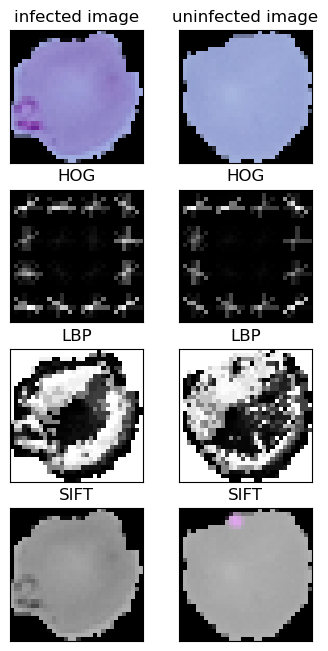

In [42]:
plt.figure(figsize=(4,10))
for i, img in enumerate(data_vis, start=1):
    plt.subplot(5, 2, i)
    plt.title(img_name_arr[i-1])
    frame1 = plt.gca()
    for tick in frame1.axes.get_xticklines():
        tick.set_visible(False)
    for tick in frame1.axes.get_yticklines():
        tick.set_visible(False)
    for xlabel_i in frame1.axes.get_xticklabels():
        xlabel_i.set_visible(False)
    for xlabel_i in frame1.axes.get_yticklabels():
        xlabel_i.set_visible(False)
    plt.imshow(data_vis[i-1], cmap='gray')
plt.savefig('output/feature_visualization.png')
plt.show()

In [43]:
hog_train = get_hog(train_imgs, name='hog_train', save=True)
hog_val = get_hog(val_imgs, name='hog_val', save=True)

Feature saved with name cache/hog_train.pkl
Feature saved with name cache/hog_val.pkl


In [44]:
hog_train = load_feature('cache/hog_train.pkl')
hog_val = load_feature('cache/hog_val.pkl')

In [45]:
hog_train.shape, hog_val.shape

((17636, 324), (4410, 324))

In [46]:
lbp_train = get_lbp(train_imgs, name='lbp_train', save=True)
lbp_val = get_lbp(val_imgs, name='lbp_val', save=True)

Feature saved with name cache/lbp_train.pkl
Feature saved with name cache/lbp_val.pkl


In [47]:
lbp_train = load_feature('cache/lbp_train.pkl')
lbp_val = load_feature('cache/lbp_val.pkl')

In [48]:
lbp_train.shape, lbp_val.shape

((17636, 1024), (4410, 1024))

In [49]:
kaze_train = get_kaze(train_imgs, name='kaze_train', save=True)
kaze_val = get_kaze(val_imgs, name='kaze_val', save=True)

Feature saved with name cache/kaze_train.pkl
Feature saved with name cache/kaze_val.pkl


In [50]:
kaze_train = load_feature('cache/kaze_train.pkl')
kaze_val = load_feature('cache/kaze_val.pkl')

In [51]:
kaze_train.shape, kaze_val.shape

((17636, 2048), (4410, 2048))

In [52]:
sift_train = get_sift(train_imgs, name='sift_train', save=True)
sift_val = get_sift(val_imgs, name='sift_val', save=True)

Feature saved with name cache/sift_train.pkl
Feature saved with name cache/sift_val.pkl


In [53]:
sift_train = load_feature('cache/sift_train.pkl')
sift_val = load_feature('cache/sift_val.pkl')

In [54]:
sift_train.shape, sift_val.shape

((17636, 1920), (4410, 1920))

In [55]:
flat_rgb_train = get_flattened(train_imgs, None, name='flat_rgb_train', save=True)
flat_rgb_val = get_flattened(val_imgs, None, name='flat_rgb_val', save=True)

Feature saved with name cache/flat_rgb_train.pkl
Feature saved with name cache/flat_rgb_val.pkl


In [56]:
flat_rgb_train = load_feature('cache/flat_rgb_train.pkl')
flat_rgb_val = load_feature('cache/flat_rgb_val.pkl')

In [57]:
flat_rgb_train.shape, flat_rgb_val.shape

((17636, 3072), (4410, 3072))

In [58]:
flat_gray_train = get_flattened(train_imgs, name='flat_gray_train', save=True)
flat_gray_val = get_flattened(val_imgs, name='flat_gray_val', save=True)

Feature saved with name cache/flat_gray_train.pkl
Feature saved with name cache/flat_gray_val.pkl


In [59]:
flat_gray_train = load_feature('cache/flat_gray_train.pkl')
flat_gray_val = load_feature('cache/flat_gray_val.pkl')

In [60]:
flat_gray_train.shape, flat_gray_val.shape

((17636, 1024), (4410, 1024))

In [61]:
hist_train = get_color_hist(train_imgs, name='hist_train', save=True)
hist_val = get_color_hist(val_imgs, name='hist_val', save=True)

Feature saved with name cache/hist_train.pkl
Feature saved with name cache/hist_val.pkl


In [62]:
hist_train = load_feature('cache/hist_train.pkl')
hist_val = load_feature('cache/hist_val.pkl')

In [63]:
hist_train.shape, hist_val.shape

((17636, 512), (4410, 512))

# Reduce Features by PCA

In [64]:
norm_hog_train, norm_hog_val = norm_features_zscore(hog_train, hog_val)

In [65]:
pca = PCA(n_components=10)
pca_hog_train = pca.fit_transform(norm_hog_train)
pca_hog_val = pca.transform(norm_hog_val)

In [66]:
np.save('cache/pca_hog_train.npy', pca_hog_train)
np.save('cache/pca_hog_val.npy', pca_hog_val)

In [67]:
pca_hog_train = np.load('cache/pca_hog_train.npy')
pca_hog_val = np.load('cache/pca_hog_val.npy')

In [68]:
pca_hog_train.shape, pca_hog_val.shape

((17636, 10), (4410, 10))

In [69]:
norm_lbp_train, norm_lbp_val = norm_features_zscore(lbp_train, lbp_val)

In [70]:
pca = PCA(n_components=10)
pca_lbp_train = pca.fit_transform(norm_lbp_train)
pca_lbp_val = pca.transform(norm_lbp_val)

In [71]:
np.save('cache/pca_lbp_train.npy', pca_lbp_train)
np.save('cache/pca_lbp_val.npy', pca_lbp_val)

In [72]:
pca_lbp_train = np.load('cache/pca_lbp_train.npy')
pca_lbp_val = np.load('cache/pca_lbp_val.npy')

In [73]:
pca_lbp_train.shape, pca_lbp_val.shape

((17636, 10), (4410, 10))

In [74]:
norm_kaze_train, norm_kaze_val = norm_features_zscore(kaze_train, kaze_val)

In [75]:
pca = PCA(n_components=10)
pca_kaze_train = pca.fit_transform(norm_kaze_train)
pca_kaze_val = pca.transform(norm_kaze_val)

In [76]:
np.save('cache/pca_kaze_train.npy', pca_kaze_train)
np.save('cache/pca_kaze_val.npy', pca_kaze_val)

In [77]:
pca_kaze_train = np.load('cache/pca_kaze_train.npy')
pca_kaze_val = np.load('cache/pca_kaze_val.npy')

In [78]:
pca_kaze_train.shape, pca_kaze_val.shape

((17636, 10), (4410, 10))

In [79]:
norm_sift_train, norm_sift_val = norm_features_zscore(sift_train, sift_val)

In [80]:
pca = PCA(n_components=5)
pca_sift_train = pca.fit_transform(norm_sift_train)
pca_sift_val = pca.transform(norm_sift_val)

In [81]:
np.save('cache/pca_sift_train.npy', pca_sift_train)
np.save('cache/pca_sift_val.npy', pca_sift_val)

In [82]:
pca_sift_train = np.load('cache/pca_sift_train.npy')
pca_sift_val = np.load('cache/pca_sift_val.npy')

In [83]:
pca_sift_train.shape, pca_sift_val.shape

((17636, 5), (4410, 5))

In [84]:
norm_flat_rgb_train, norm_flat_rgb_val = norm_features_zscore(flat_rgb_train, flat_rgb_val)

In [85]:
pca = PCA(n_components=10)
pca_flat_rgb_train = pca.fit_transform(norm_flat_rgb_train)
pca_flat_rgb_val = pca.transform(norm_flat_rgb_val)

In [86]:
np.save('cache/pca_flat_rgb_train.npy', pca_flat_rgb_train)
np.save('cache/pca_flat_rgb_val.npy', pca_flat_rgb_val)

In [87]:
pca_flat_rgb_train = np.load('cache/pca_flat_rgb_train.npy')
pca_flat_rgb_val = np.load('cache/pca_flat_rgb_val.npy')

In [88]:
pca_flat_rgb_train.shape, pca_flat_rgb_val.shape

((17636, 10), (4410, 10))

In [89]:
norm_flat_gray_train, norm_flat_gray_val = norm_features_zscore(flat_gray_train, flat_gray_val)

In [90]:
pca = PCA(n_components=6)
pca_flat_gray_train = pca.fit_transform(norm_flat_gray_train)
pca_flat_gray_val = pca.transform(norm_flat_gray_val)

In [91]:
np.save('cache/pca_flat_gray_train.npy', pca_flat_gray_train)
np.save('cache/pca_flat_gray_val.npy', pca_flat_gray_val)

In [92]:
pca_flat_gray_train = np.load('cache/pca_flat_gray_train.npy')
pca_flat_gray_val = np.load('cache/pca_flat_gray_val.npy')

In [93]:
pca_flat_gray_train.shape, pca_flat_gray_val.shape

((17636, 6), (4410, 6))

In [94]:
# norm_hist_train, norm_hist_val = norm_features_minmax(hist_train, hist_val)
norm_hist_train, norm_hist_val = norm_features_zscore(hist_train, hist_val)

In [95]:
pca = PCA(n_components=10)
pca_hist_train = pca.fit_transform(norm_hist_train)
pca_hist_val = pca.transform(norm_hist_val)

In [96]:
np.save('cache/pca_hist_train.npy', pca_hist_train)
np.save('cache/pca_hist_val.npy', pca_hist_val)

In [97]:
pca_hist_train = np.load('cache/pca_hist_train.npy')
pca_hist_val = np.load('cache/pca_hist_val.npy')

In [98]:
pca_hist_train.shape, pca_hist_val.shape

((17636, 10), (4410, 10))

# Feature PCA variance comparison

In [99]:
pca_array = []
pca_array.append(pca_hog_train)
pca_array.append(pca_lbp_train)
pca_array.append(pca_sift_train)
#pca_array.append(pca_surf_train)
pca_array.append(pca_kaze_train)
pca_array.append(pca_hist_train)
pca_array.append(pca_flat_gray_train)
pca_array.append(pca_flat_rgb_train)
len(pca_array)

7

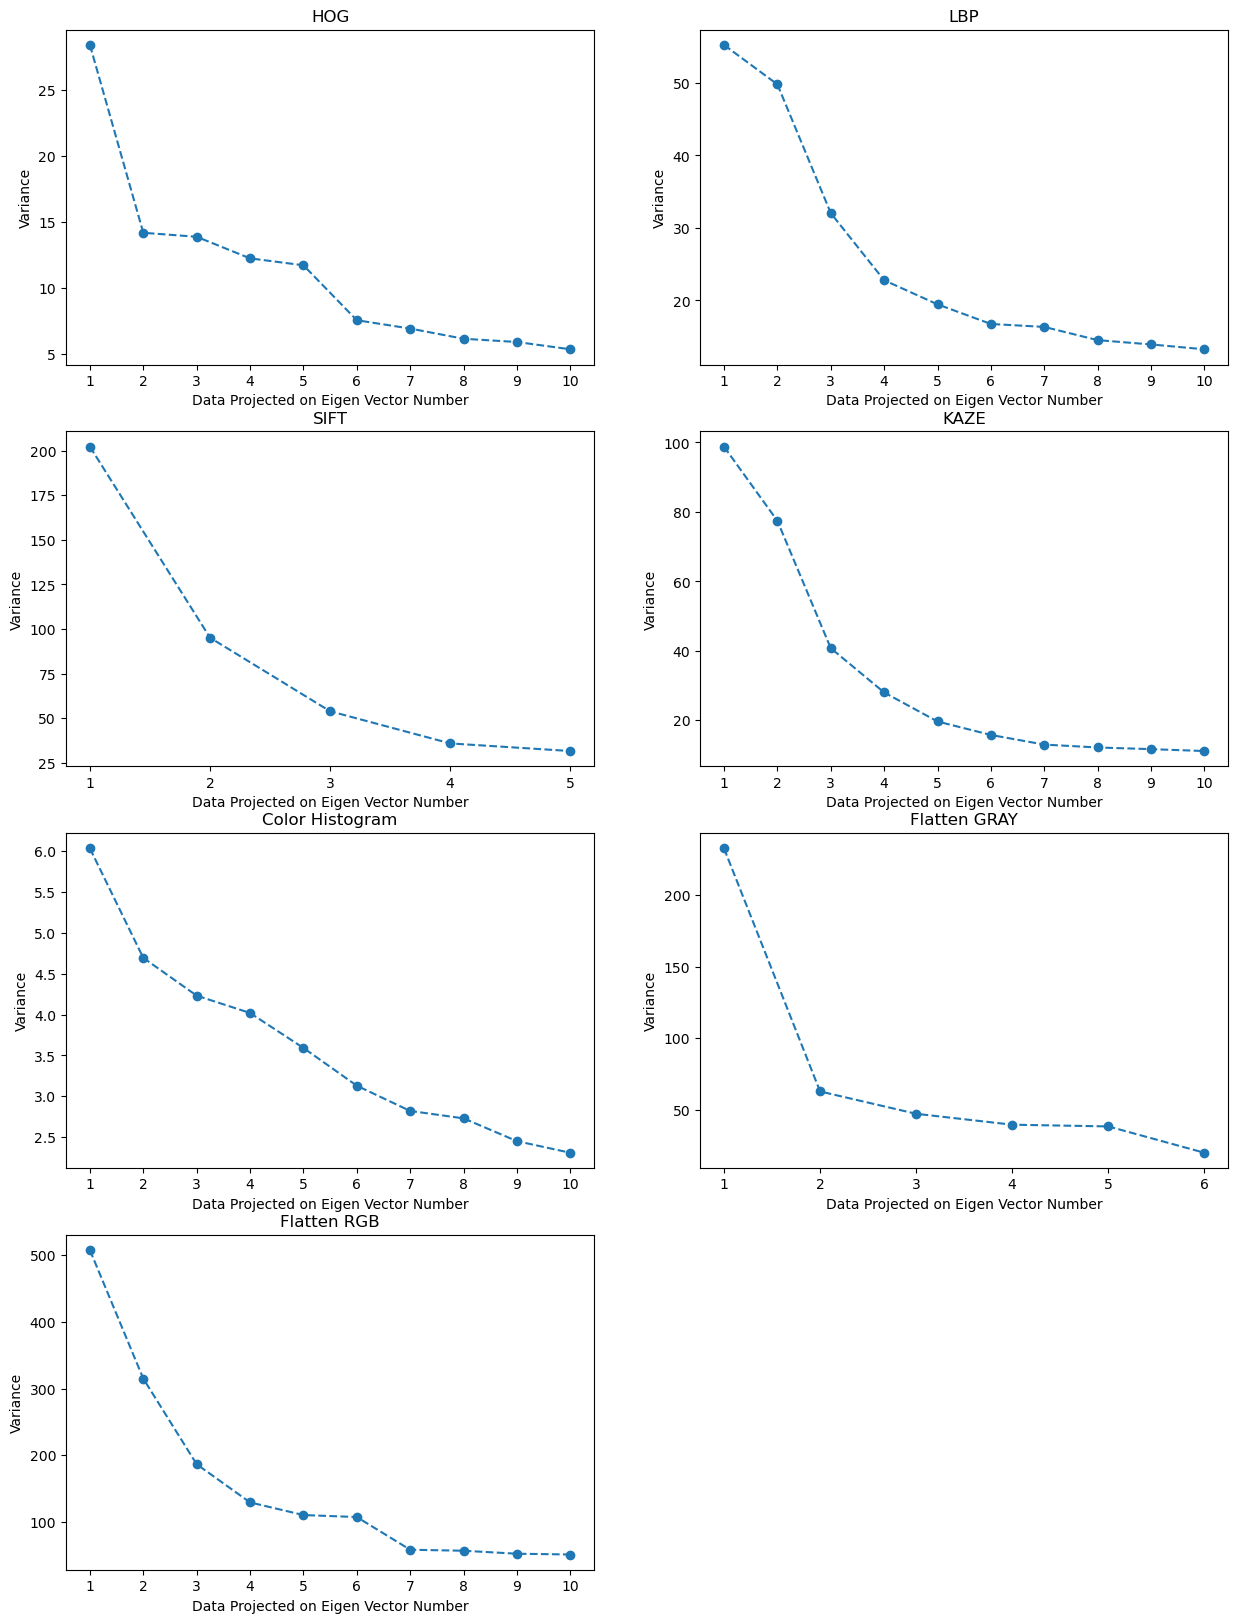

In [100]:
pca_projection(pca_array, ['HOG', 'LBP', 'SIFT', 'KAZE', 'Color Histogram', 'Flatten GRAY', 'Flatten RGB'])

# Reduce Features by LDA

In [101]:
lda = LDA()
lda_hog_train = lda.fit_transform(norm_hog_train, train_y)
lda_hog_val = lda.transform(norm_hog_val)

In [102]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [103]:
np.save('cache/lda_hog_train.npy', lda_hog_train)
np.save('cache/lda_hog_val.npy', lda_hog_val)

In [104]:
lda_hog_train = np.load('cache/lda_hog_train.npy')
lda_hog_val = np.load('cache/lda_hog_val.npy')

In [105]:
lda_hog_train.shape, lda_hog_val.shape

((17636, 1), (4410, 1))

In [106]:
lda = LDA()
lda_lbp_train = lda.fit_transform(norm_lbp_train, train_y)
lda_lbp_val = lda.transform(norm_lbp_val)

In [107]:
np.save('cache/lda_lbp_train.npy', lda_lbp_train)
np.save('cache/lda_lbp_val.npy', lda_lbp_val)

In [108]:
lda_lbp_train = np.load('cache/lda_lbp_train.npy')
lda_lbp_val = np.load('cache/lda_lbp_val.npy')

In [109]:
lda_lbp_train.shape, lda_lbp_val.shape

((17636, 1), (4410, 1))

In [110]:
lda = LDA()
lda_sift_train = lda.fit_transform(norm_sift_train, train_y)
lda_sift_val = lda.transform(norm_sift_val)

In [111]:
np.save('cache/lda_sift_train.npy', lda_sift_train)
np.save('cache/lda_sift_val.npy', lda_sift_val)

In [112]:
lda_sift_train = np.load('cache/lda_sift_train.npy')
lda_sift_val = np.load('cache/lda_sift_val.npy')

In [113]:
lda_sift_train.shape, lda_sift_val.shape

((17636, 1), (4410, 1))

In [114]:
lda = LDA()
lda_hist_train = lda.fit_transform(norm_hist_train, train_y)
lda_hist_val = lda.transform(norm_hist_val)

In [115]:
np.save('cache/lda_hist_train.npy', lda_hist_train)
np.save('cache/lda_hist_val.npy', lda_hist_val)

In [116]:
lda_hist_train = np.load('cache/lda_hist_train.npy')
lda_hist_val = np.load('cache/lda_hist_val.npy')

In [117]:
lda_hist_train.shape, lda_hist_val.shape

((17636, 1), (4410, 1))

# Combine Features normal

In [118]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([hog_train, hist_train,  flat_rgb_train, lbp_train, kaze_train, sift_train], 
                  [hog_val, hist_val,  flat_rgb_val, lbp_val, kaze_val, sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [119]:
features_train.shape, features_val.shape

((17636, 8900), (4410, 8900))

# Combine Features PCA

In [120]:
features_train = None
features_val = None
evs = []
for ft, fv in zip([pca_hog_train, pca_lbp_train, pca_sift_train, pca_flat_rgb_train, pca_hist_train], 
                  [pca_hog_val, pca_lbp_val, pca_sift_val, pca_flat_rgb_val, pca_hist_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train is None:
        features_train = ft
        features_val = fv
    else:
        features_train = combine_features([features_train, ft])
        features_val = combine_features([features_val, fv])

In [121]:
features_train.shape, features_val.shape

((17636, 45), (4410, 45))

# Combine Features LDA

In [122]:
features_train_lda = None
features_val_lda = None
evs = []
for ft, fv in zip([lda_hog_train, lda_hist_train, lda_lbp_train, lda_sift_train], 
                  [lda_hog_val, lda_hist_val, lda_lbp_val, lda_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train_lda is None:
        features_train_lda = ft
        features_val_lda = fv
    else:
        features_train_lda = combine_features([features_train_lda, ft])
        features_val_lda = combine_features([features_val_lda, fv])

In [123]:
features_train_lda.shape, features_val_lda.shape

((17636, 4), (4410, 4))

# LDA on PCA

In [124]:
lda = LDA()
lda_on_pca_train = lda.fit_transform(features_train, train_y)
lda_on_pca_val = lda.transform(features_val)

In [125]:
np.save('cache/lda_on_pca_train.npy', lda_on_pca_train)
np.save('cache/lda_on_pca_val.npy', lda_on_pca_val)

In [126]:
lda_on_pca_train = np.load('cache/lda_on_pca_train.npy')
lda_on_pca_val = np.load('cache/lda_on_pca_val.npy')

In [127]:
lda_on_pca_train.shape, lda_on_pca_val.shape

((17636, 1), (4410, 1))

Combine Features

In [129]:
features_t = pca_hist_train
features_v = pca_hist_val

In [130]:
features_t.shape, features_v.shape

((17636, 10), (4410, 10))

# Classification

PCA

In [132]:
model1 = train_model(features_train, train_y, model_name='RF', validation=(features_val, val_y))

Validation Accuracy in 'RF' = 0.882766439909297
[[1950  251]
 [ 266 1943]]
Recall in 'RF' = 0.8859609268514311
Precision in 'RF' = 0.8799638989169675
F1 Score in 'RF' = 0.8829522300203757


In [133]:
prob1 = model1.predict_proba(features_val)
prob10 = prob1[:,0].reshape(prob1.shape[0], 1)
prob11 = prob1[:,1].reshape(prob1.shape[0], 1)

In [134]:
model2 = train_model(features_train, train_y, model_name='BAG', validation=(features_val, val_y))

Validation Accuracy in 'BAG' = 0.890249433106576
[[1975  226]
 [ 258 1951]]
Recall in 'BAG' = 0.8973194002726034
Precision in 'BAG' = 0.8844603672189879
F1 Score in 'BAG' = 0.8908434821831304


In [135]:
prob2 = model2.predict_proba(features_val)
prob20 = prob2[:,0].reshape(prob2.shape[0], 1)
prob21 = prob2[:,1].reshape(prob2.shape[0], 1)

In [136]:
model3 = train_model(features_train, train_y, model_name='ADA', validation=(features_val, val_y))

Validation Accuracy in 'ADA' = 0.8750566893424037
[[1916  285]
 [ 266 1943]]
Recall in 'ADA' = 0.870513402998637
Precision in 'ADA' = 0.8780934922089826
F1 Score in 'ADA' = 0.8742870180241843


In [137]:
prob3 = model3.predict_proba(features_val)
prob30 = prob3[:,0].reshape(prob3.shape[0], 1)
prob31 = prob3[:,1].reshape(prob3.shape[0], 1)

In [138]:

model4 = train_model(features_train, train_y, model_name='NB', validation=(features_val, val_y))

Validation Accuracy in 'NB' = 0.6972789115646258
[[1059 1142]
 [ 193 2016]]
Recall in 'NB' = 0.4811449341208542
Precision in 'NB' = 0.8458466453674122
F1 Score in 'NB' = 0.6133796698523024


In [139]:
prob4 = model4.predict_proba(features_val)
prob40 = prob4[:,0].reshape(prob4.shape[0], 1)
prob41 = prob4[:,1].reshape(prob4.shape[0], 1)

In [140]:
model5 = train_model(features_train, train_y, model_name='SVM', validation=(features_val, val_y))

Validation Accuracy in 'SVM' = 0.8714285714285714
[[1890  311]
 [ 256 1953]]
Recall in 'SVM' = 0.8587005906406179
Precision in 'SVM' = 0.880708294501398
F1 Score in 'SVM' = 0.8695652173913044


In [141]:
prob5 = model5.predict_proba(features_val)
prob50 = prob5[:,0].reshape(prob5.shape[0], 1)
prob51 = prob5[:,1].reshape(prob5.shape[0], 1)

In [142]:
model6 = train_model(np.array(features_train), train_y, model_name='XGB', validation=(features_val, val_y))

Validation Accuracy in 'XGB' = 0.9151927437641724
[[2002  199]
 [ 175 2034]]
Recall in 'XGB' = 0.9095865515674694
Precision in 'XGB' = 0.9196141479099679
F1 Score in 'XGB' = 0.914572864321608


In [143]:
prob6 = model6.predict_proba(features_val)
prob60 = prob6[:,0].reshape(prob6.shape[0], 1)
prob61 = prob6[:,1].reshape(prob6.shape[0], 1)

In [144]:
model7 = train_model(np.array(features_train), train_y, model_name='KNN', validation=(features_val, val_y))

Validation Accuracy in 'KNN' = 0.7848072562358277
[[1605  596]
 [ 353 1856]]
Recall in 'KNN' = 0.7292139936392549
Precision in 'KNN' = 0.8197139938712973
F1 Score in 'KNN' = 0.7718201490742967


In [145]:
prob7 = model7.predict_proba(features_val)
prob70 = prob7[:,0].reshape(prob7.shape[0], 1)
prob71 = prob7[:,1].reshape(prob7.shape[0], 1)

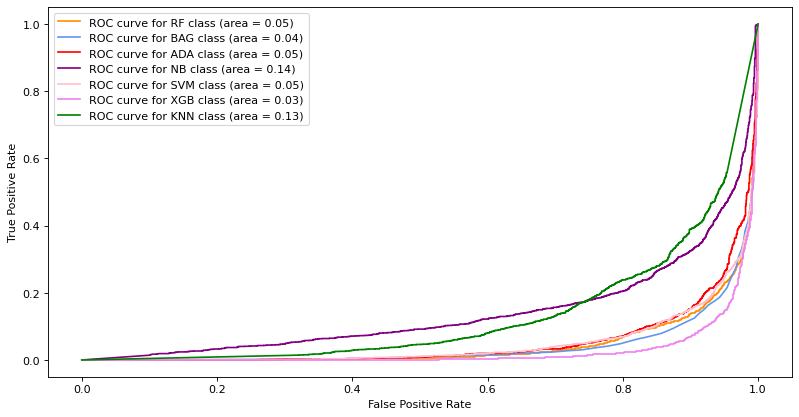

In [146]:
prob = np.concatenate((prob10, prob20, prob30, prob40, prob50, prob60, prob70), axis=1)
plot_combine_roc(val_y, prob)

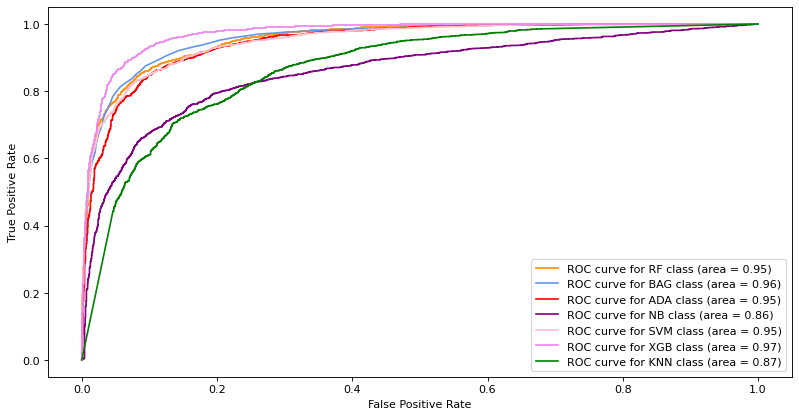

In [147]:
prob = np.concatenate((prob11, prob21, prob31, prob41, prob51, prob61, prob71), axis=1)
plot_combine_roc(val_y, prob)

LDA

In [148]:
model8 = train_model(features_train_lda, train_y, model_name='RF', validation=(features_val_lda, val_y))

Validation Accuracy in 'RF' = 0.8621315192743764
[[1901  300]
 [ 308 1901]]
Recall in 'RF' = 0.8636983189459336
Precision in 'RF' = 0.8605703938433681
F1 Score in 'RF' = 0.8621315192743764


In [149]:
prob8 = model8.predict_proba(features_val_lda)
prob80 = prob8[:,0].reshape(prob8.shape[0], 1)
prob81 = prob8[:,1].reshape(prob8.shape[0], 1)

In [150]:
model9 = train_model(features_train_lda, train_y, model_name='BAG', validation=(features_val_lda, val_y))

Validation Accuracy in 'BAG' = 0.8537414965986394
[[1880  321]
 [ 324 1885]]
Recall in 'BAG' = 0.854157201272149
Precision in 'BAG' = 0.852994555353902
F1 Score in 'BAG' = 0.8535754824063564


In [151]:
prob9 = model9.predict_proba(features_val_lda)
prob90 = prob9[:,0].reshape(prob9.shape[0], 1)
prob91 = prob9[:,1].reshape(prob9.shape[0], 1)

In [152]:
model10 = train_model(features_train_lda, train_y, model_name='ADA', validation=(features_val_lda, val_y))


Validation Accuracy in 'ADA' = 0.8600907029478458
[[1874  327]
 [ 290 1919]]
Recall in 'ADA' = 0.8514311676510677
Precision in 'ADA' = 0.865988909426987
F1 Score in 'ADA' = 0.8586483390607101


In [153]:
prob10 = model10.predict_proba(features_val_lda)
prob100 = prob10[:,0].reshape(prob10.shape[0], 1)
prob101 = prob10[:,1].reshape(prob10.shape[0], 1)

In [154]:
model11 = train_model(features_train_lda, train_y, model_name='NB', validation=(features_val_lda, val_y))


Validation Accuracy in 'NB' = 0.8473922902494331
[[1808  393]
 [ 280 1929]]
Recall in 'NB' = 0.8214447978191731
Precision in 'NB' = 0.8659003831417624
F1 Score in 'NB' = 0.8430869666588948


In [155]:
prob11 = model11.predict_proba(features_val_lda)
prob110 = prob11[:,0].reshape(prob11.shape[0], 1)
prob111 = prob11[:,1].reshape(prob11.shape[0], 1)

In [156]:
model12 = train_model(features_train_lda, train_y, model_name='SVM', validation=(features_val_lda, val_y))


Validation Accuracy in 'SVM' = 0.8648526077097506
[[1932  269]
 [ 327 1882]]
Recall in 'SVM' = 0.8777828259881872
Precision in 'SVM' = 0.8552456839309429
F1 Score in 'SVM' = 0.8663677130044845


In [157]:
prob12 = model12.predict_proba(features_val_lda)
prob120 = prob12[:,0].reshape(prob12.shape[0], 1)
prob121 = prob12[:,1].reshape(prob12.shape[0], 1)

In [158]:
model13 = train_model(features_train_lda, train_y, model_name='XGB', validation=(features_val_lda, val_y))


Validation Accuracy in 'XGB' = 0.8541950113378685
[[1874  327]
 [ 316 1893]]
Recall in 'XGB' = 0.8514311676510677
Precision in 'XGB' = 0.8557077625570776
F1 Score in 'XGB' = 0.8535641084035528


In [159]:
prob13 = model13.predict_proba(features_val_lda)
prob130 = prob13[:,0].reshape(prob13.shape[0], 1)
prob131 = prob13[:,1].reshape(prob13.shape[0], 1)

In [160]:
model14 = train_model(features_train_lda, train_y, model_name='KNN', validation=(features_val_lda, val_y))


Validation Accuracy in 'KNN' = 0.8512471655328798
[[1888  313]
 [ 343 1866]]
Recall in 'KNN' = 0.8577919127669241
Precision in 'KNN' = 0.8462572837292693
F1 Score in 'KNN' = 0.851985559566787


In [161]:
prob14 = model14.predict_proba(features_val_lda)
prob140 = prob14[:,0].reshape(prob14.shape[0], 1)
prob141 = prob14[:,1].reshape(prob14.shape[0], 1)

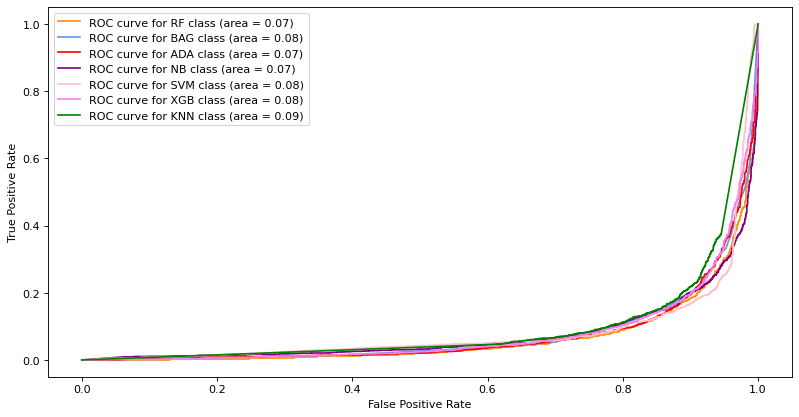

In [162]:
prob = np.concatenate((prob80, prob90, prob100, prob110, prob120, prob130, prob140), axis=1)
plot_combine_roc(val_y, prob)

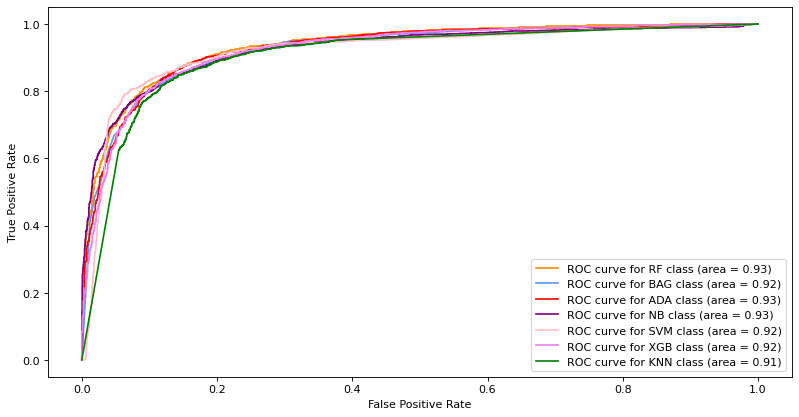

In [163]:
prob = np.concatenate((prob81, prob91, prob101, prob111, prob121, prob131, prob141), axis=1)
plot_combine_roc(val_y, prob)

LDA on PCA

In [164]:
model15 = train_model(lda_on_pca_train, train_y, model_name='RF', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'RF' = 0.836281179138322
[[1921  280]
 [ 442 1767]]
Recall in 'RF' = 0.8727850976828714
Precision in 'RF' = 0.8129496402877698
F1 Score in 'RF' = 0.8418054338299737


In [165]:
prob15 = model15.predict_proba(lda_on_pca_val)
prob150 = prob15[:,0].reshape(prob15.shape[0], 1)
prob151 = prob15[:,1].reshape(prob15.shape[0], 1)

In [166]:
model16 = train_model(lda_on_pca_train, train_y, model_name='BAG', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'BAG' = 0.7623582766439909
[[1681  520]
 [ 528 1681]]
Recall in 'BAG' = 0.7637437528396184
Precision in 'BAG' = 0.7609778180172023
F1 Score in 'BAG' = 0.7623582766439908


In [167]:
prob16 = model16.predict_proba(lda_on_pca_val)
prob160 = prob16[:,0].reshape(prob16.shape[0], 1)
prob161 = prob16[:,1].reshape(prob16.shape[0], 1)

In [168]:
model17 = train_model(lda_on_pca_train, train_y, model_name='ADA', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'ADA' = 0.8412698412698413
[[1975  226]
 [ 474 1735]]
Recall in 'ADA' = 0.8973194002726034
Precision in 'ADA' = 0.8064516129032258
F1 Score in 'ADA' = 0.849462365591398


In [169]:
prob17 = model17.predict_proba(lda_on_pca_val)
prob170 = prob17[:,0].reshape(prob17.shape[0], 1)
prob171 = prob17[:,1].reshape(prob17.shape[0], 1)

In [170]:
model18 = train_model(lda_on_pca_train, train_y, model_name='NB', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'NB' = 0.8321995464852607
[[1721  480]
 [ 260 1949]]
Recall in 'NB' = 0.7819173103134939
Precision in 'NB' = 0.8687531549722363
F1 Score in 'NB' = 0.8230511716881874


In [171]:
prob18 = model18.predict_proba(lda_on_pca_val)
prob180 = prob18[:,0].reshape(prob18.shape[0], 1)
prob181 = prob18[:,1].reshape(prob18.shape[0], 1)

In [172]:
model19 = train_model(lda_on_pca_train, train_y, model_name='SVM', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'SVM' = 0.8417233560090703
[[1915  286]
 [ 412 1797]]
Recall in 'SVM' = 0.8700590640617901
Precision in 'SVM' = 0.8229480017189514
F1 Score in 'SVM' = 0.8458480565371026


In [173]:
prob19 = model19.predict_proba(lda_on_pca_val)
prob190 = prob19[:,0].reshape(prob19.shape[0], 1)
prob191 = prob19[:,1].reshape(prob19.shape[0], 1)

In [174]:
model20 = train_model(lda_on_pca_train, train_y, model_name='XGB', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'XGB' = 0.8369614512471655
[[1929  272]
 [ 447 1762]]
Recall in 'XGB' = 0.8764198091776465
Precision in 'XGB' = 0.8118686868686869
F1 Score in 'XGB' = 0.8429102031898623


In [175]:
prob20 = model20.predict_proba(lda_on_pca_val)
prob200 = prob20[:,0].reshape(prob20.shape[0], 1)
prob201 = prob20[:,1].reshape(prob20.shape[0], 1)

In [176]:
model21 = train_model(lda_on_pca_train, train_y, model_name='KNN', validation=(lda_on_pca_val, val_y))


Validation Accuracy in 'KNN' = 0.7825396825396825
[[1735  466]
 [ 493 1716]]
Recall in 'KNN' = 0.7882780554293503
Precision in 'KNN' = 0.7787253141831239
F1 Score in 'KNN' = 0.783472567170919


In [177]:
prob21 = model21.predict_proba(lda_on_pca_val)
prob210 = prob21[:,0].reshape(prob21.shape[0], 1)
prob211 = prob21[:,1].reshape(prob21.shape[0], 1)

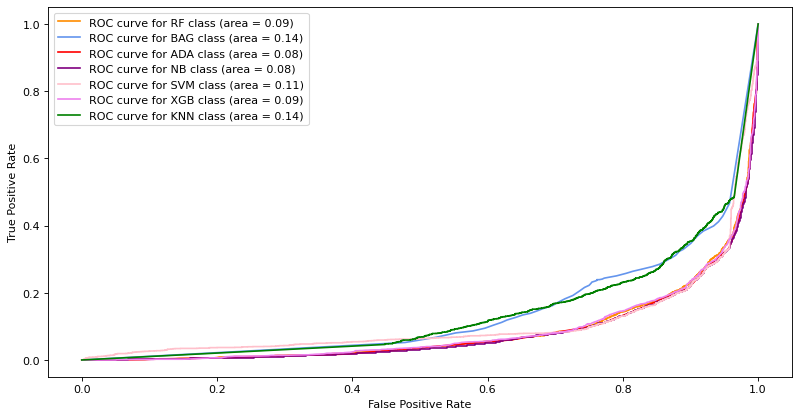

In [178]:
prob = np.concatenate((prob150, prob160, prob170, prob180, prob190, prob200, prob210), axis=1)
plot_combine_roc(val_y, prob)

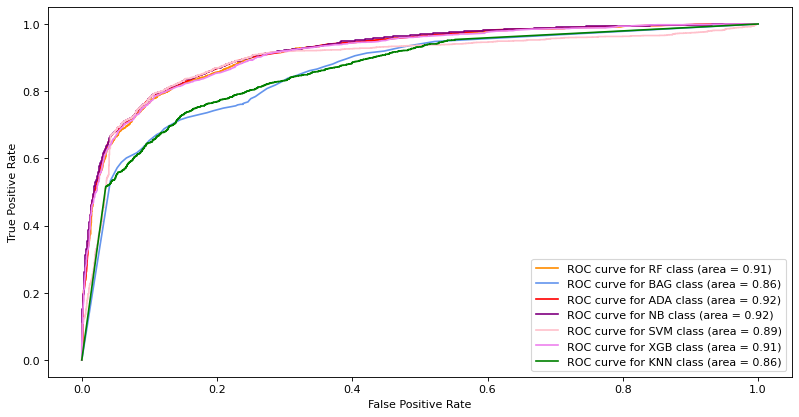

In [179]:
prob = np.concatenate((prob151, prob161, prob171, prob181, prob191, prob201, prob211), axis=1)
plot_combine_roc(val_y, prob)

Testing

In [180]:
hog_comp_train = combine_features([hog_train, hog_val], horizontal=False)
lbp_comp_train = combine_features([lbp_train, lbp_val], horizontal=False)
kaze_comp_train = combine_features([kaze_train, kaze_val], horizontal=False)
sift_comp_train = combine_features([sift_train, sift_val], horizontal=False)
#surf_comp_train = combine_features([surf_train, surf_val], horizontal=False)
flat_rgb_comp_train = combine_features([flat_rgb_train, flat_rgb_val], horizontal=False)
flat_gray_comp_train = combine_features([flat_gray_train, flat_gray_val], horizontal=False)
hist_comp_train = combine_features([hist_train, hist_val], horizontal=False)

In [181]:
data_y = np.hstack([train_y, val_y])


In [182]:
pcas_array = []

pca = PCA(n_components=10)
pca_hog_comp_train = pca.fit_transform(hog_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=30)
pca_lbp_comp_train = pca.fit_transform(lbp_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_kaze_comp_train = pca.fit_transform(kaze_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=15)
pca_sift_comp_train = pca.fit_transform(sift_comp_train)
pcas_array.append(pca)

#pca = PCA(n_components=5)
#pca_surf_comp_train = pca.fit_transform(surf_comp_train)
#pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_rgb_comp_train = pca.fit_transform(flat_rgb_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=20)
pca_flat_gray_comp_train = pca.fit_transform(flat_gray_comp_train)
pcas_array.append(pca)

pca = PCA(n_components=10)
pca_hist_comp_train = pca.fit_transform(hist_comp_train)
pcas_array.append(pca)

In [183]:
reduced_train_features=[pca_hog_comp_train,
                        pca_lbp_comp_train,
                        pca_kaze_comp_train,
                        pca_sift_comp_train,
                        #pca_surf_comp_train,
                        pca_flat_rgb_comp_train,
                        pca_flat_gray_comp_train,
                        pca_hist_comp_train]

In [184]:
hog_test = get_hog(test_x, name='hog_test', save=True)
lbp_test = get_lbp(test_x, name='lbp_test', save=True)
kaze_test = get_kaze(test_x, name='kaze_test', save=True)
sift_test = get_sift(test_x, name='sift_test', save=True)
#surf_test = get_surf(test_x, name='surf_test', save=True)
flat_rgb_test = get_flattened(test_x, None, name='flat_rgb_test', save=True)
flat_gray_test = get_flattened(test_x, name='flat_gray_test', save=True)
hist_test = get_color_hist(test_x, name='hist_test', save=True)

Feature saved with name cache/hog_test.pkl
Feature saved with name cache/lbp_test.pkl
Feature saved with name cache/kaze_test.pkl
Feature saved with name cache/sift_test.pkl
Feature saved with name cache/flat_rgb_test.pkl
Feature saved with name cache/flat_gray_test.pkl
Feature saved with name cache/hist_test.pkl


In [185]:
test_features= [hog_test,
                lbp_test,
                kaze_test,
                sift_test,
                #surf_test,
                flat_rgb_test,
                flat_gray_test,
                hist_test]

In [186]:
features_comp_train = None
features_test = None
comp_pcas = []

for i, (f_train, f_test) in enumerate(zip(reduced_train_features, 
                                          test_features)):
    if i == 6:
        continue
    f_test = pcas_array[i].transform(f_test)
    
    if features_comp_train is None:
        features_comp_train = f_train
        features_test = f_test
    else:
        features_comp_train = combine_features([features_comp_train, f_train])
        features_test = combine_features([features_test, f_test])

In [187]:
features_comp_train.shape, features_test.shape

((22046, 115), (5512, 115))

In [188]:
comp_model = train_model(features_comp_train, data_y, model_name='XGB')

In [189]:
y_hat = comp_model.predict(features_test)

In [190]:
acc = metrics.accuracy_score(test_y, y_hat)
print(acc)
cm = metrics.confusion_matrix(test_y, y_hat)
print(cm)
precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])
f1 = 2*(recall * precision) / (recall + precision)
print(precision, recall, f1)

0.8122278664731495
[[2247  531]
 [ 504 2230]]
0.816793893129771 0.8088552915766739 0.812805208898535


Hyper Parameter Tuning

In [191]:
clf = RandomForestClassifier(n_estimators=200)

param_dist = {"max_depth": [3, None],
              "class_weight" : ["balanced", "balanced_subsample", None],
              "min_samples_split": randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=20, cv=5, return_train_score=True)

In [192]:
random_search.fit(features_train_lda, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=200),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025EBE3B5910>},
                   return_train_score=True)

In [193]:
print(random_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_class_weight', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [194]:
a1 = random_search.cv_results_['param_bootstrap']
a2 = random_search.cv_results_['param_class_weight']
a3 = random_search.cv_results_['param_criterion']
a4 = random_search.cv_results_['param_max_depth']
a5 = random_search.cv_results_['param_min_samples_split']

a6 = random_search.cv_results_['mean_train_score']
a7 = random_search.cv_results_['mean_test_score']

In [195]:
print(random_search.best_params_)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}


In [196]:
arr = []
for key in random_search.best_params_.keys():
    arr.append(key)
    
arr.append('mean_train_score')
arr.append('mean_test_score')
print(arr)

['bootstrap', 'class_weight', 'criterion', 'max_depth', 'min_samples_split', 'mean_train_score', 'mean_test_score']


In [197]:
write_csv('output/random_forest.csv', a1, a2, a3, a4, a5, a6, a7, arr)

In [198]:
#np.savez('output/random_forest.npz', a1=a1, a2=a2, a3=a3, a4=a4, a5=a5, a6=a6, a7=a7, arr=arr)

In [199]:
y1 = random_search.predict(features_val_lda)
metrics.accuracy_score(y1, val_y)

0.8582766439909297

Confusion Matrix

In [200]:
y_hat1 = model1.predict(features_val)
y_hat2 = model2.predict(features_val)
y_hat3 = model3.predict(features_val)
y_hat4 = model4.predict(features_val)
y_hat5 = model5.predict(features_val)
y_hat6 = model6.predict(features_val)
y_hat7 = model7.predict(features_val)

In [201]:
class MetricTools:
    @staticmethod
    def accuracy(y, y_hat):
        """
        y [np array]: actual labels
        y_hat [np array]: predicted labels
        
        return: accuracy between 0 and 1
        """
        return np.sum(y == y_hat) / len(y)
    
    @staticmethod
    def prec_recall(y, y_hat, nclasses):
        """
        y [np array]: actual labels
        y_hat [np array]: predicted labels
        nclasses [integer]: number of classes in the dataset.
        
        return: precision, recall
        """
        cm = MetricTools.confusion_matrix(y, y_hat, nclasses)
        
        rec = cm[0,0] / np.sum(cm[0,:])
        prec = cm[0,0] / np.sum(cm[:,0])
        
        return prec, rec
    
    @staticmethod
    def confusion_matrix(y, y_hat, nclasses):
        """
        y [np array]: actual labels [values between 0 to nclasses-1]
        y_hat [np array]: predicted labels [values between 0 to nclasses-1]
        nclasses [integer]: number of classes in the dataset.
        
        return: confusion matrix of shape [nclasses, nclasses]
        """
        y = y.astype(np.int64)
        y_hat = y_hat.astype(np.int64)

        conf_mat = np.zeros((nclasses, nclasses))

        for i in range(y_hat.shape[0]):
            true, pred = y[i], y_hat[i]
            conf_mat[true, pred] += 1

        return conf_mat
    
    @staticmethod
    def roc_curve(probs, test_y, label, is_log_prob=True):
        """
        probs: Default Log-Posteriors log(P(C_label/x)) for class label. 
               Could be normal probs if is_log_prob = False.
        test_y: actual labels of test data.
        label: Class for which ROC is to be formed.
        is_log_prob: Tells if probs is log-prob or not
        
        return: False Positive Rate (FPR), True Positive Rate (TPR) for the given values
        """
        thresholds = np.linspace(0, 1, num=100)

        x = []
        y = []

        if is_log_prob:
            probs = np.exp(probs)
        
        min_val = np.min(probs)
        max_val = np.max(probs)

        for thresh in thresholds:
            conf_mat = np.zeros((2,2))
            pred = None
            actual = None
            for i in range(test_y.shape[0]):
                if (probs[i] - min_val) / (max_val - min_val) > thresh:
                    pred = 0
                else:
                    pred = 1

                if test_y[i] == label:
                    actual = 0
                else:
                    actual = 1
                conf_mat[actual, pred] += 1

            fpr = conf_mat[1, 0] / np.sum(conf_mat[1, :])
            tpr = conf_mat[0, 0] / np.sum(conf_mat[0, :])

            x.append(fpr)
            y.append(tpr)

        return x, y

In [202]:
cm1 = MetricTools.confusion_matrix(val_y, y_hat1, 2)
cm2 = MetricTools.confusion_matrix(val_y, y_hat2, 2)
cm3 = MetricTools.confusion_matrix(val_y, y_hat3, 2)
cm4 = MetricTools.confusion_matrix(val_y, y_hat4, 2)
cm5 = MetricTools.confusion_matrix(val_y, y_hat5, 2)
cm6 = MetricTools.confusion_matrix(val_y, y_hat6, 2)
cm7 = MetricTools.confusion_matrix(val_y, y_hat7, 2)

In [203]:
print(cm1)
print(cm2)
print(cm3)
print(cm4)
print(cm5)
print(cm6)
print(cm7)

[[1950.  251.]
 [ 266. 1943.]]
[[1975.  226.]
 [ 258. 1951.]]
[[1916.  285.]
 [ 266. 1943.]]
[[1059. 1142.]
 [ 193. 2016.]]
[[1890.  311.]
 [ 256. 1953.]]
[[2002.  199.]
 [ 175. 2034.]]
[[1605.  596.]
 [ 353. 1856.]]


In [204]:
class PlotTools:
    @staticmethod
    def confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        
        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()
                
    @staticmethod
    def roc_curves(rocs, title, figsize=(8,5), path=None, filename=None):
        """
        rocs: Dictionary of the form {'label': [FPR, TPR]} containing multiple ROC values.
              where FPR = False positive rate; TPR = True positive rate
              label = Title for which the ROC values are given
        title: Title of the plot
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        """
        plt.figure(figsize=figsize)
        for l, roc in rocs.items():
            plt.plot(roc[0], roc[1], label=l)

        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.xlim((-0.05, 1.08))
        plt.title(title)
        plt.legend()
        
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

    @staticmethod
    def table(data, row_index, col_index, title, figsize=(8,3), col_widths=[0.5], path=None, filename=None):
        """
        Plots the data in tabular format.
        
        data: 2d array data for the table to be plotted.
        row_index: Headers for Rows of the table.
        col_index: Headers for Columns of the table.
        title: Title of the table.
        figsize: tupple (width, height) representiong size of the plot.
        col_widths: width of each column in the table.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)
        """
        df = pd.DataFrame(data)
        plt.figure(figsize=figsize)
        ax = plt.subplot(111, frame_on=False) 
        ax.xaxis.set_visible(False)  
        ax.yaxis.set_visible(False)
        plt.title(title)
        table(ax, df, loc='upper right', rowLabels=row_index, colLabels=col_index, colWidths=col_widths)
        if path:
            if filename is None:
                plt.savefig(path + title + '.png')
            else:
                plt.savefig(path + filename + '.png')
        plt.show()

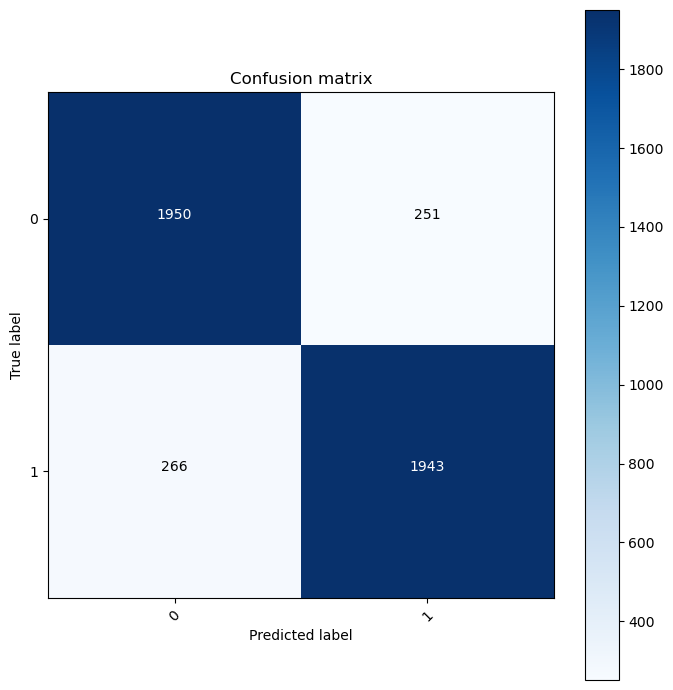

In [205]:
PlotTools.confusion_matrix(cm1, list(range(2)))


In [206]:
features_train1 = None
features_val1 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_hog_train, pca_lbp_train], 
                  [pca_hist_val, pca_hog_val, pca_lbp_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train1 is None:
        features_train1 = ft
        features_val1 = fv
    else:
        features_train1 = combine_features([features_train1, ft])
        features_val1 = combine_features([features_val1, fv])
features_train1.shape, features_val1.shape

((17636, 30), (4410, 30))

In [207]:
model1 = train_model(features_train1, train_y, model_name='XGB', validation=(features_val1, val_y))
prob1 = model1.predict_proba(features_val1)

Validation Accuracy in 'XGB' = 0.909297052154195
[[2001  200]
 [ 200 2009]]
Recall in 'XGB' = 0.9091322126306225
Precision in 'XGB' = 0.9091322126306225
F1 Score in 'XGB' = 0.9091322126306225


In [208]:
features_train2 = None
features_val2 = None
evs = []
for ft, fv in zip([pca_hist_train, pca_flat_gray_train, pca_flat_rgb_train], 
                  [pca_hist_val, pca_flat_gray_val, pca_flat_rgb_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train2 is None:
        features_train2 = ft
        features_val2 = fv
    else:
        features_train2 = combine_features([features_train2, ft])
        features_val2 = combine_features([features_val2, fv])
features_train2.shape, features_val2.shape

((17636, 26), (4410, 26))

In [209]:
model2 = train_model(features_train2, train_y, model_name='XGB', validation=(features_val2, val_y))
prob2 = model2.predict_proba(features_val2)

Validation Accuracy in 'XGB' = 0.8791383219954648
[[1867  334]
 [ 199 2010]]
Recall in 'XGB' = 0.8482507950931395
Precision in 'XGB' = 0.9036786060019361
F1 Score in 'XGB' = 0.8750878837590813


In [210]:
features_train3 = None
features_val3 = None
evs = []
for ft, fv in zip([pca_kaze_train, pca_sift_train], 
                  [pca_kaze_val, pca_sift_val]):    
#     scaler = preprocessing.StandardScaler()
#     ft = scaler.fit_transform(ft)
#     fv = scaler.transform(fv)
#     ft = preprocessing.normalize(ft)
#     fv = preprocessing.normalize(fv)
    if features_train3 is None:
        features_train3 = ft
        features_val3 = fv
    else:
        features_train3 = combine_features([features_train3, ft])
        features_val3 = combine_features([features_val3, fv])
features_train3.shape, features_val3.shape

((17636, 15), (4410, 15))

In [211]:
model3 = train_model(features_train3, train_y, model_name='XGB', validation=(features_val3, val_y))
prob3 = model3.predict_proba(features_val3)

Validation Accuracy in 'XGB' = 0.7578231292517007
[[1504  697]
 [ 371 1838]]
Recall in 'XGB' = 0.6833257610177192
Precision in 'XGB' = 0.8021333333333334
F1 Score in 'XGB' = 0.7379784102060843


In [212]:
prob1 = model1.predict_proba(features_val1)
prob2 = model2.predict_proba(features_val2)
prob3 = model3.predict_proba(features_val3)
#prob4 = model4.predict_proba(features_val4)
#prob5 = model5.score(features_val, )
#prob6 = model6.predict_proba(features_val6)

In [213]:
prob = (prob1 + prob2 + prob3 + prob4 + prob6) / 5
y_hat = np.argmax(prob, axis=1)

In [214]:
metrics.accuracy_score(val_y, y_hat)


0.9052154195011338